In [75]:
import os
from pathlib import Path
from datetime import datetime, timedelta
from io import StringIO

import numpy as np
import pandas as pd
import requests

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.patches import Rectangle
import matplotlib.gridspec as gridspec
from matplotlib.ticker import FuncFormatter

import plotly.graph_objs as go
from dateutil.tz import tzutc, tzlocal
import math

# Pull Data from NOAA and USGS (stream height and tides)

## Pull the last 24 hours of stream height data from Waikane USGS station

This is the function for requesting USGS data

In [76]:
def USGS_Data_Request(site, start_date, end_date, parameter):
    """
    Download USGS instantaneous data from NWIS API.
    Handles errors gracefully, converts to metric units, and adjusts for HST.
    """
    
    param_units = {
        "00045": "in",       # Precipitation
        "00060": "ft3_s",    # Discharge
        "00065": "ft"        # Gage height
    }

    if parameter not in param_units:
        raise ValueError("Unsupported parameter code. Use '00045', '00060', or '00065'.")

    unit_col = param_units[parameter]

    url = (
        f"https://waterservices.usgs.gov/nwis/iv/?format=json"
        f"&sites={site}&startDT={start_date}&endDT={end_date}"
        f"&parameterCd={parameter}&siteStatus=all"
    )

    try:
        response = requests.get(url, timeout=60)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching data from USGS: {e}")
        return pd.DataFrame()

    # Handle case where no timeSeries are returned
    if not data.get('value', {}).get('timeSeries'):
        print(f"No data available for site {site} and parameter {parameter}")
        return pd.DataFrame()

    # Parse valid entries
    rows = []
    for ts in data['value']['timeSeries']:
        for entry in ts['values'][0]['value']:
            val_str = entry.get("value", "")
            try:
                val = float(val_str)
            except ValueError:
                val = None

            rows.append({
                "DateTime": entry["dateTime"],
                unit_col: val
            })

    # Build DataFrame
    df = pd.DataFrame(rows)
    df['DateTime'] = pd.to_datetime(df['DateTime']).dt.tz_localize(None)
    df = df[['DateTime', unit_col]]

    return df

Using the function, I will pull the last 24 hours of stream height data

In [77]:
#Waikane

site = '16294900'
parameter = "00065"

# Set start and end dates in UTC with time included
start_date = (datetime.utcnow() - timedelta(days=3)).strftime('%Y-%m-%dT%H:%M')
end_date = datetime.utcnow().strftime('%Y-%m-%dT%H:%M')

df_16294900_H = USGS_Data_Request(site, start_date, end_date, parameter)

C:\Users\anne0\AppData\Local\Temp\ipykernel_8952\3018553234.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_date = (datetime.utcnow() - timedelta(days=3)).strftime('%Y-%m-%dT%H:%M')
C:\Users\anne0\AppData\Local\Temp\ipykernel_8952\3018553234.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().strftime('%Y-%m-%dT%H:%M')


In [78]:
#Waiahole

site = '16294100'
parameter = "00065"

# Set start and end dates in UTC with time included
start_date = (datetime.utcnow() - timedelta(days=3)).strftime('%Y-%m-%dT%H:%M')
end_date = datetime.utcnow().strftime('%Y-%m-%dT%H:%M')

df_16294100_H = USGS_Data_Request(site, start_date, end_date, parameter)

C:\Users\anne0\AppData\Local\Temp\ipykernel_8952\2092448235.py:7: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  start_date = (datetime.utcnow() - timedelta(days=3)).strftime('%Y-%m-%dT%H:%M')
C:\Users\anne0\AppData\Local\Temp\ipykernel_8952\2092448235.py:8: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  end_date = datetime.utcnow().strftime('%Y-%m-%dT%H:%M')


In [79]:
# Ensure DateTime is sorted
df_16294100_H = df_16294100_H.sort_values('DateTime').reset_index(drop=True)

# Get the max datetime
max_dt_16294100 = df_16294100_H['DateTime'].max()
print("Max datetime:", max_dt_16294100)

# Compute the cutoff datetime (24 hours before max)
cutoff_dt_16294100 = max_dt_16294100 - pd.Timedelta(hours=24)
print("24 hours earlier:", cutoff_dt_16294100)

# Find the first row where datetime is greater than or equal to cutoff
earlier_index_16294100 = df_16294100_H[df_16294100_H['DateTime'] >= cutoff_dt_16294100].index[0]
print("Index at least 24 hours before max:", earlier_index_16294100)

Max datetime: 2025-06-17 13:35:00
24 hours earlier: 2025-06-16 13:35:00
Index at least 24 hours before max: 449


In [80]:
# Ensure DateTime is sorted
df_16294900_H = df_16294900_H.sort_values('DateTime').reset_index(drop=True)

# Get the max datetime
max_dt_16294900 = df_16294900_H['DateTime'].max()
print("Max datetime:", max_dt_16294900)

# Compute the cutoff datetime (24 hours before max)
cutoff_dt_16294900 = max_dt_16294900 - pd.Timedelta(hours=24)
print("24 hours earlier:", cutoff_dt_16294900)

# Find the first row where datetime is greater than or equal to cutoff
earlier_index_16294900 = df_16294900_H[df_16294900_H['DateTime'] >= cutoff_dt_16294900].index[0]
print("Index at least 24 hours before max:", earlier_index_16294900)

Max datetime: 2025-06-17 13:25:00
24 hours earlier: 2025-06-16 13:25:00
Index at least 24 hours before max: 413


## Pull the predicted tides for today from the nearest API NOAA station (Mokuoloe)

In [81]:
# Station and API settings
station_id = "1612480"  # Moku
datum = "MSL"
units = "metric"
time_zone = "lst"
clock = "24hour"
interval = "hilo"
product = "predictions"
output_file = "Mokuoloe_tide_predictions.csv"

# Time range: last 3 days
end_date = datetime.today()
start_date = end_date - timedelta(days=3)

# URL and parameters
base_url = "https://api.tidesandcurrents.noaa.gov/api/prod/datagetter"
params = {
    "begin_date": start_date.strftime("%Y%m%d"),
    "end_date": end_date.strftime("%Y%m%d"),
    "station": station_id,
    "product": product,
    "datum": datum,
    "units": units,
    "time_zone": time_zone,
    "clock": clock,
    "interval": interval,
    "format": "csv"
}

# Download and save
print(f"Downloading: {params['begin_date']} to {params['end_date']}")
response = requests.get(base_url, params=params)

if response.status_code == 200:
    if "No tide data was found" in response.text:
        print("❌ No tide data found for this range.")
    else:
        df_Mokouloe = pd.read_csv(StringIO(response.text))
        df_Mokouloe.to_csv(output_file, index=False)
        print(f"\n✅ Tide data saved to {output_file} ({len(df_Mokouloe)} rows)")
else:
    print(f"❌ Request failed (status code {response.status_code})")
    print(response.text)


Downloading: 20250614 to 20250617

✅ Tide data saved to Mokuoloe_tide_predictions.csv (12 rows)


### Convert the predicted tides for Mokouloe to tides for Waikane

In [82]:
def convert_Mokouloe_to_Waikane(Source_df, HEIGHT_OFFSET_HIGH, HEIGHT_OFFSET_LOW, TIME_OFFSET_HIGH, TIME_OFFSET_LOW):
    """
    Adjust tide predictions from Moku o Lo‘e to Waikāne using NOAA time and height offsets.
    Converts predictions from meters to feet and renames column to 'Prediction_ft_MSL'.

    Parameters:
        Source_df (pd.DataFrame): Input tide prediction DataFrame with 'Date Time', 'Prediction', and 'Type'.
        HEIGHT_OFFSET_HIGH (float): Height multiplier for high tides.
        HEIGHT_OFFSET_LOW (float): Height multiplier for low tides.
        TIME_OFFSET_HIGH (int): Time offset in minutes for high tides.
        TIME_OFFSET_LOW (int): Time offset in minutes for low tides.

    Returns:
        pd.DataFrame: Adjusted DataFrame with feet predictions and updated column name.
    """

    required = ['Date Time', 'Prediction', 'Type']
    df = Source_df.copy()
    df.columns = df.columns.str.strip()  # clean column names

    if not all(col in df.columns for col in required):
        raise ValueError(f"Missing required columns. Found columns: {df.columns.tolist()}")

    df['Date Time'] = pd.to_datetime(df['Date Time'])

    def apply_offsets(row):
        if row['Type'] == 'H':
            row['Date Time'] += pd.Timedelta(minutes=TIME_OFFSET_HIGH)
            row['Prediction'] *= HEIGHT_OFFSET_HIGH
        elif row['Type'] == 'L':
            row['Date Time'] += pd.Timedelta(minutes=TIME_OFFSET_LOW)
            row['Prediction'] *= HEIGHT_OFFSET_LOW
        return row

    # Apply NOAA time/height offsets
    df = df.apply(apply_offsets, axis=1)

    # Convert meters to feet and rename column
    df['Prediction_ft_MSL'] = df['Prediction'] * 3.28084
    return df[['Date Time', 'Prediction_ft_MSL', 'Type']]


In [83]:
df_Waikane_HILO = convert_Mokouloe_to_Waikane(df_Mokouloe, HEIGHT_OFFSET_HIGH = 1.13, HEIGHT_OFFSET_LOW = 1, TIME_OFFSET_HIGH = -22, TIME_OFFSET_LOW = -4)
display(df_Waikane_HILO.head())

,Date Time,Prediction_ft_MSL,Type
0,2025-06-14 09:29:00,-1.374672,L
1,2025-06-14 17:24:00,1.449574,H
2,2025-06-15 10:08:00,-1.190945,L
3,2025-06-15 18:02:00,1.368012,H
4,2025-06-16 02:03:00,-0.272310,L


### Create a time series using the HIGH and LOW and convert to feet

In [84]:
def convert_HILO_to_5min_series(df):
    df = df.copy()
    
    # Convert to datetime and round to nearest 5 min
    df["Date Time"] = pd.to_datetime(df["Date Time"])
    df["Date Time"] = df["Date Time"].dt.round("5min")
    df = df.sort_values("Date Time").reset_index(drop=True)

    # Function to generate sine interpolation between two tide points
    def fit_sine_wave(t0, t1, y0, y1):
        duration = (t1 - t0).total_seconds()
        if duration <= 0:
            return [], []

        steps = int(duration / 300) + 1  # 5-minute intervals
        times = [t0 + timedelta(seconds=i * 300) for i in range(steps)]
        elapsed = np.array([(t - t0).total_seconds() for t in times])
        omega = np.pi / duration  # 0 to pi for half-wave
        amplitude = (y1 - y0) / 2
        offset = (y1 + y0) / 2
        levels = amplitude * np.sin(omega * elapsed - np.pi/2) + offset
        return times, levels

    # Build full 5-minute interpolated time series
    full_times = []
    full_levels = []

    for i in range(len(df) - 1):
        t0 = df.loc[i, "Date Time"]
        t1 = df.loc[i + 1, "Date Time"]
        y0 = df.loc[i, "Prediction_ft_MSL"]
        y1 = df.loc[i + 1, "Prediction_ft_MSL"]
        seg_times, seg_levels = fit_sine_wave(t0, t1, y0, y1)
        full_times.extend(seg_times)
        full_levels.extend(seg_levels)

    # Final DataFrame
    df_5min = pd.DataFrame({
        "Datetime": full_times,
        "Predicted_ft_MSL": [round(lvl, 2) for lvl in full_levels]
    }).drop_duplicates("Datetime").sort_values("Datetime").reset_index(drop=True)

    return df_5min


In [85]:
df_Waikane_5min = convert_HILO_to_5min_series(df_Waikane_HILO)
display(df_Waikane_5min.head())

,Datetime,Predicted_ft_MSL
0,2025-06-14 09:30:00,-1.37
1,2025-06-14 09:35:00,-1.37
2,2025-06-14 09:40:00,-1.37
3,2025-06-14 09:45:00,-1.37
4,2025-06-14 09:50:00,-1.36


# Visualize the Data


## Pull in the singificant values for stream and tide

In [86]:
# Define relative path to the folder
folder_path = os.path.join('.', 'Flooding_Thresholds')

# Define full file paths
stream16294900_thresholds = os.path.join(folder_path, 'Waikane_16294900_stream_flood_thresholds.csv')
stream16294100_thresholds = os.path.join(folder_path, 'Waiahole_16294100_stream_flood_thresholds.csv')

tide_thresholds = os.path.join(folder_path, 'Mokuoloe-Waikane_tide_flood_thresholds.csv')

# Read CSVs
df_stream16294900_thresholds = pd.read_csv(stream16294900_thresholds)
df_stream16294100_thresholds = pd.read_csv(stream16294100_thresholds)
df_tide_thresholds = pd.read_csv(tide_thresholds)


## Graph of Stream Height

### Colored significance of stream height

In [87]:
stream16294900_thresholds

'.\\Flooding_Thresholds\\Waikane_16294900_stream_flood_thresholds.csv'

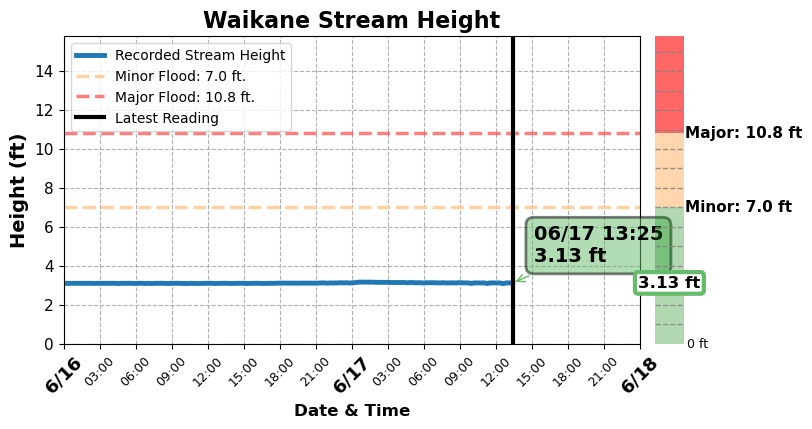

In [88]:
# Create a figure with GridSpec for main plot and colorbar
df_stream16294900_thresholds = df_stream16294900_thresholds.set_index("Flood")
minor = df_stream16294900_thresholds.Stream_height_ft["minor"]
major = df_stream16294900_thresholds.Stream_height_ft["major"]
max = df_stream16294900_thresholds.Stream_height_ft["major"] + 5

fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

# Main plot axis
ax = fig.add_subplot(gs[0])

# Plot stream height
ax.plot(df_16294900_H['DateTime'], df_16294900_H['ft'], color='#1f77b4', linewidth=3.5, label='Recorded Stream Height')

# Threshold lines
ax.axhline(y=minor, color='#ffcc99', linestyle='--', linewidth=2.5, alpha=0.9, label=f'Minor Flood: {minor} ft.')
ax.axhline(y=major, color='red', linestyle='--', linewidth=2.5, alpha=0.5, label=f'Major Flood: {major} ft.')

# Last data point
last_time = df_16294900_H['DateTime'].iloc[-1]
last_height = df_16294900_H['ft'].iloc[-1]

# Determine color based on stream height
if last_height < minor:
    box_color = '#66bb6a'     # green
elif last_height < major:
    box_color = '#ffa726'     # orange
else:
    box_color = '#ef5350'     # red

# Vertical marker at last data point
ax.axvline(x=last_time, color='black', linestyle='-', linewidth=3, label='Latest Reading')

# Annotation for last value
ax.annotate(f"{last_time.strftime('%m/%d %H:%M')}\n{last_height:.2f} ft",
            xy=(last_time, last_height),
            xytext=(15, 15),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=box_color, linewidth=2, alpha=0.5),
            arrowprops=dict(arrowstyle='->', color=box_color),
            fontsize=14, fontweight='bold')

# Axis formatting
today = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
yesterday = today - timedelta(days=1)
tick_times = pd.date_range(start=yesterday, end=today + timedelta(days=1, hours=1), freq='3h')
ax.set_xticks(tick_times)

def custom_time_formatter(x, pos):
    dt = mdates.num2date(x)
    if dt.hour == 0:
        return rf"$\bf{{{dt.month}/{dt.day}}}$"
    else:
        return dt.strftime('%H:%M')

ax.xaxis.set_major_formatter(plt.FuncFormatter(custom_time_formatter))
ax.set_xlim([yesterday, today + timedelta(days=1)])
ax.set_ylim(0, max)

# Labels and styling
ax.grid(True, which='major', linestyle='--', linewidth=0.8)
ax.set_title('Waikane Stream Height', fontsize=16, fontweight='bold')
ax.set_xlabel('Date & Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Height (ft)', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45)

for label in ax.get_xticklabels():
    if '/' in label.get_text():
        label.set_fontsize(13)
        label.set_fontweight('bold')
    else:
        label.set_fontsize(9)
ax.tick_params(axis='y', labelsize=11)

# ➕ Enhanced Color Bar (Right Side)
cbar_ax = fig.add_subplot(gs[1])
cbar_ax.set_ylim(0, max)
cbar_ax.set_xlim(0, 1)
cbar_ax.axis('off')

# Colored blocks for flood risk
cbar_ax.add_patch(Rectangle((0, 0), 1, minor, facecolor='green', alpha=0.3))
cbar_ax.add_patch(Rectangle((0, minor), 1, major - minor, facecolor='#ffcc99', alpha=0.8))
cbar_ax.add_patch(Rectangle((0, major), 1, max - major, facecolor='red', alpha=0.6))

# Gray dashed lines every 1 ft
for y in range(1, round(max)):
    cbar_ax.axhline(y=y, color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Labels on color bar
cbar_ax.text(1.1, 0, '0 ft', va='center', fontsize=9)
cbar_ax.text(1.05, minor, f'Minor: {minor} ft', va='center', ha='left', fontsize=11, fontweight='bold', linespacing=1.2)
cbar_ax.text(1.05, major, f'Major: {major} ft', va='center', ha='left', fontsize=11, fontweight='bold', linespacing=1.2)


# Dynamic marker on color bar
cbar_ax.axhline(y=last_height, color='black', linestyle='-', linewidth=2)
cbar_ax.text(0.5, last_height, f'{last_height:.2f} ft', color="black",
             va='center', ha='center', fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', edgecolor=box_color, linewidth=3, boxstyle='round,pad=0.2'))

# Legend and show
ax.legend()
plt.show()

df_stream16294900_thresholds = df_stream16294900_thresholds.reset_index()

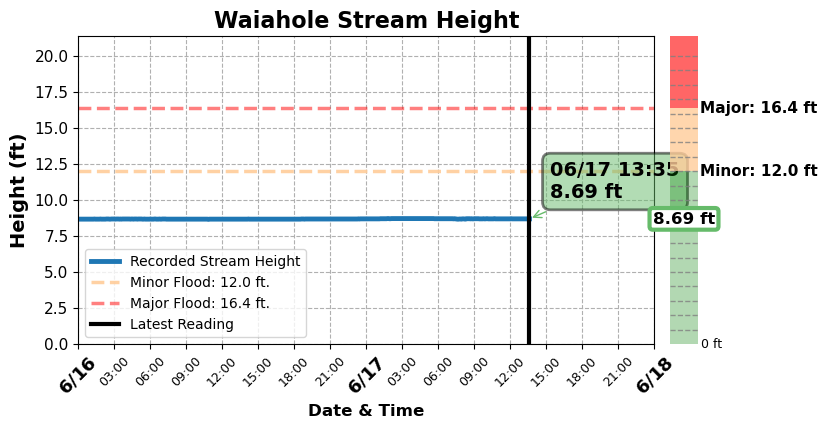

In [89]:
# Create a figure with GridSpec for main plot and colorbar
df_stream16294100_thresholds = df_stream16294100_thresholds.set_index("Flood")
minor = df_stream16294100_thresholds.Stream_height_ft["minor"]
major = df_stream16294100_thresholds.Stream_height_ft["major"]
max = df_stream16294100_thresholds.Stream_height_ft["major"] + 5

fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

# Main plot axis
ax = fig.add_subplot(gs[0])

# Plot stream height
ax.plot(df_16294100_H['DateTime'], df_16294100_H['ft'], color='#1f77b4', linewidth=3.5, label='Recorded Stream Height')

# Threshold lines
ax.axhline(y=minor, color='#ffcc99', linestyle='--', linewidth=2.5, alpha=0.9, label=f'Minor Flood: {minor} ft.')
ax.axhline(y=major, color='red', linestyle='--', linewidth=2.5, alpha=0.5, label=f'Major Flood: {major} ft.')

# Last data point
last_time = df_16294100_H['DateTime'].iloc[-1]
last_height = df_16294100_H['ft'].iloc[-1]

# Determine color based on stream height
if last_height < minor:
    box_color = '#66bb6a'     # green
elif last_height < major:
    box_color = '#ffa726'     # orange
else:
    box_color = '#ef5350'     # red

# Vertical marker at last data point
ax.axvline(x=last_time, color='black', linestyle='-', linewidth=3, label='Latest Reading')

# Annotation for last value
ax.annotate(f"{last_time.strftime('%m/%d %H:%M')}\n{last_height:.2f} ft",
            xy=(last_time, last_height),
            xytext=(15, 15),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.4', facecolor=box_color, linewidth=2, alpha=0.5),
            arrowprops=dict(arrowstyle='->', color=box_color),
            fontsize=14, fontweight='bold')

# Axis formatting
today = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
yesterday = today - timedelta(days=1)
tick_times = pd.date_range(start=yesterday, end=today + timedelta(days=1, hours=1), freq='3h')
ax.set_xticks(tick_times)

def custom_time_formatter(x, pos):
    dt = mdates.num2date(x)
    if dt.hour == 0:
        return rf"$\bf{{{dt.month}/{dt.day}}}$"
    else:
        return dt.strftime('%H:%M')

ax.xaxis.set_major_formatter(plt.FuncFormatter(custom_time_formatter))
ax.set_xlim([yesterday, today + timedelta(days=1)])
ax.set_ylim(0, max)

# Labels and styling
ax.grid(True, which='major', linestyle='--', linewidth=0.8)
ax.set_title('Waiahole Stream Height', fontsize=16, fontweight='bold')
ax.set_xlabel('Date & Time', fontsize=12, fontweight='bold')
ax.set_ylabel('Height (ft)', fontsize=14, fontweight='bold')
plt.setp(ax.get_xticklabels(), rotation=45)

for label in ax.get_xticklabels():
    if '/' in label.get_text():
        label.set_fontsize(13)
        label.set_fontweight('bold')
    else:
        label.set_fontsize(9)
ax.tick_params(axis='y', labelsize=11)

# ➕ Enhanced Color Bar (Right Side)
cbar_ax = fig.add_subplot(gs[1])
cbar_ax.set_ylim(0, max)
cbar_ax.set_xlim(0, 1)
cbar_ax.axis('off')

# Colored blocks for flood risk
cbar_ax.add_patch(Rectangle((0, 0), 1, minor, facecolor='green', alpha=0.3))
cbar_ax.add_patch(Rectangle((0, minor), 1, major - minor, facecolor='#ffcc99', alpha=0.8))
cbar_ax.add_patch(Rectangle((0, major), 1, max - major, facecolor='red', alpha=0.6))

# Gray dashed lines every 1 ft
for y in range(1, round(max)):
    cbar_ax.axhline(y=y, color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Labels on color bar
cbar_ax.text(1.1, 0, '0 ft', va='center', fontsize=9)
cbar_ax.text(1.05, minor, f'Minor: {minor} ft', va='center', ha='left', fontsize=11, fontweight='bold', linespacing=1.2)
cbar_ax.text(1.05, major, f'Major: {major} ft', va='center', ha='left', fontsize=11, fontweight='bold', linespacing=1.2)


# Dynamic marker on color bar
cbar_ax.axhline(y=last_height, color='black', linestyle='-', linewidth=2)
cbar_ax.text(0.5, last_height, f'{last_height:.2f} ft', color="black",
             va='center', ha='center', fontsize=12, fontweight='bold',
             bbox=dict(facecolor='white', edgecolor=box_color, linewidth=3, boxstyle='round,pad=0.2'))

# Legend and show
ax.legend()
plt.show()

df_stream16294100_thresholds = df_stream16294100_thresholds.reset_index()

## Graph of Tides

In [90]:
# Ensure datetime format
df_16294900_H["DateTime"] = pd.to_datetime(df_16294900_H["DateTime"])
latest_stream_time = df_16294900_H["DateTime"].iloc[-1]

df_Waikane_HILO["Date Time"] = pd.to_datetime(df_Waikane_HILO["Date Time"])
df_Waikane_5min["Datetime"] = pd.to_datetime(df_Waikane_5min["Datetime"])

# Time bounds
today = datetime.today().replace(hour=0, minute=0, second=0, microsecond=0)
x_start = today - timedelta(days=1)
x_end = today + timedelta(days=1)
tick_times = pd.date_range(start=x_start, end=x_end + timedelta(hours=1), freq='3h')

# Filter tide data
df_highs_window = df_Waikane_HILO[df_Waikane_HILO["Type"] == "H"]
df_lows_window = df_Waikane_HILO[df_Waikane_HILO["Type"] == "L"]
df_combined_filtered = pd.concat([df_highs_window, df_lows_window])

df_filtered_5min = df_Waikane_5min[(df_Waikane_5min["Datetime"] >= x_start) & (df_Waikane_5min["Datetime"] <= x_end)]
df_filtered_highs = df_highs_window[(df_highs_window["Date Time"] >= x_start) & (df_highs_window["Date Time"] <= x_end)]
df_filtered_lows = df_lows_window[(df_lows_window["Date Time"] >= x_start) & (df_lows_window["Date Time"] <= x_end)]
df_combined_filtered = pd.concat([df_filtered_highs, df_filtered_lows])

'''
# Get tide level at latest stream time
closest_idx = (df_filtered_5min["Datetime"] - latest_stream_time).abs().idxmin()
closest_time = df_filtered_5min.loc[closest_idx, "Datetime"]
closest_level = df_filtered_5min.loc[closest_idx, "Predicted_ft_MSL"]


# Y-limits from df_tide
min_val = math.floor(df_tide["Height_ft"].min())
max_val = math.ceil(df_tide["Height_ft"].max())

# Extract thresholds from df_tide
df_tide = df_tide.set_index("Mokuoloe_datums")
MSL = df_tide.loc["MSL", "Height_ft"]
MHHW = df_tide.loc["MHHW", "Height_ft"]
one_year = df_tide.loc["1_yr_return", "Height_ft"]

# Determine color category of the tide level at latest stream time
if closest_level < MHHW:
    box_color = 'green'
elif MSL <= closest_level < one_year:
    box_color = 'orange'
else:
    box_color = 'red'

# Create side-by-side plot
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)

# Tide plot
ax = fig.add_subplot(gs[0])
ax.plot(df_filtered_5min["Datetime"], df_filtered_5min["Predicted_ft_MSL"],
        color='blue', linewidth=2, label='Water Level')

ax.scatter(df_combined_filtered["Date Time"], df_combined_filtered["Prediction_ft_MSL"],
           color='black', label='High/Low Tides', zorder=5)

for _, row in df_filtered_highs.iterrows():
    ax.text(row["Date Time"], row["Prediction_ft_MSL"] + 0.12,
            f'{row["Prediction_ft_MSL"]:.2f}', color='blue', ha='center', fontsize=9)

for _, row in df_filtered_lows.iterrows():
    ax.text(row["Date Time"], row["Prediction_ft_MSL"] - 0.3,
            f'{row["Prediction_ft_MSL"]:.2f}', color='blue', ha='center', fontsize=9)

ax.axvline(x=latest_stream_time, color='black', linestyle='-', linewidth=4, label='Current Stream Recording')

# Convert box_color to RGBA with transparency
face_rgba = to_rgba(box_color, alpha=0.4)

ax.annotate(f"{closest_time.strftime('%m/%d %H:%M')}\n{closest_level:.2f} ft",
            xy=(closest_time, closest_level),
            xytext=(15, 15),
            textcoords='offset points',
            bbox=dict(boxstyle='round,pad=0.4', facecolor= face_rgba, edgecolor='black', linewidth=2),
            arrowprops=dict(arrowstyle='->', color='black'),
            fontsize=12, fontweight='bold')

ax.set_title("Waikane Predicted Tides (above Mean Sea Level)", fontsize=16, fontweight='bold')
ax.set_xlabel("Date & Time", fontsize=12, fontweight='bold')
ax.set_ylabel("Predicted Tide (ft)", fontsize=14, fontweight='bold')
ax.set_xlim([x_start, x_end])
ax.set_ylim(min_val, max_val)
ax.set_xticks(tick_times)

def custom_time_formatter(x, pos):
    dt = mdates.num2date(x)
    if dt.hour == 0:
        return rf"$\bf{{{dt.month}/{dt.day}}}$"
    else:
        return dt.strftime('%H:%M')

ax.xaxis.set_major_formatter(FuncFormatter(custom_time_formatter))
plt.setp(ax.get_xticklabels(), rotation=45)
for label in ax.get_xticklabels():
    if '/' in label.get_text():
        label.set_fontsize(13)
        label.set_fontweight('bold')
    else:
        label.set_fontsize(9)

ax.tick_params(axis='y', labelsize=11)
ax.grid(True, which='major', linestyle='--', linewidth=0.8)
ax.legend(fontsize=8, loc='upper left')

# Vertical color bar like stream height chart
cbar_ax = fig.add_subplot(gs[1])
cbar_ax.set_ylim(min_val, max_val)
cbar_ax.set_xlim(0, 1)
cbar_ax.axis('off')

# Draw the tide zones
cbar_ax.add_patch(plt.Rectangle((0, -2), 1, 2, color='green', alpha=0.4))     # Below MSL# MSL to MHHW
cbar_ax.add_patch(plt.Rectangle((0, 1.07), 1, 0.80, color='orange', alpha=0.8))  # MHHW to 1yr
cbar_ax.add_patch(plt.Rectangle((0, 1.87), 1, 1.13, color='red', alpha=0.6))     # Above 1yr

# Dashed lines every 0.5 ft
for y in [i * 0.5 for i in range(-4, 7)]:
    cbar_ax.axhline(y=y, color='gray', linestyle='--', linewidth=1, alpha=0.8)

# Labels
cbar_ax.text(1.1, -2, '-2 ft', va='center', fontsize=9)
cbar_ax.text(1.05, 0, 'MSL: 0 ft', va='center', fontsize=9, fontweight='bold')
cbar_ax.text(1.05, 1.07, 'MHHW: 1.07 ft', va='center', fontsize=9, fontweight='bold')
cbar_ax.text(1.05, 1.87, '1yr: 1.87 ft', va='center', fontsize=9, fontweight='bold')
cbar_ax.text(1.1, 3, '3 ft', va='center', fontsize=9)

# Highlight current tide on bar
cbar_ax.axhline(y=closest_level, color='black', linestyle='-', linewidth=2)
cbar_ax.text(0.5, closest_level, f'{closest_level:.2f} ft', color="black",
             va='center', ha='center', fontsize=10, fontweight='bold',
             bbox=dict(facecolor='white', edgecolor= box_color, linewidth=2, boxstyle='round,pad=0.2'))

plt.show()
plt.savefig("tides.png")

df_tide = df_tide.reset_index()
'''

'\n# Get tide level at latest stream time\nclosest_idx = (df_filtered_5min["Datetime"] - latest_stream_time).abs().idxmin()\nclosest_time = df_filtered_5min.loc[closest_idx, "Datetime"]\nclosest_level = df_filtered_5min.loc[closest_idx, "Predicted_ft_MSL"]\n\n\n# Y-limits from df_tide\nmin_val = math.floor(df_tide["Height_ft"].min())\nmax_val = math.ceil(df_tide["Height_ft"].max())\n\n# Extract thresholds from df_tide\ndf_tide = df_tide.set_index("Mokuoloe_datums")\nMSL = df_tide.loc["MSL", "Height_ft"]\nMHHW = df_tide.loc["MHHW", "Height_ft"]\none_year = df_tide.loc["1_yr_return", "Height_ft"]\n\n# Determine color category of the tide level at latest stream time\nif closest_level < MHHW:\n    box_color = \'green\'\nelif MSL <= closest_level < one_year:\n    box_color = \'orange\'\nelse:\n    box_color = \'red\'\n\n# Create side-by-side plot\nfig = plt.figure(figsize=(10, 4))\ngs = gridspec.GridSpec(1, 2, width_ratios=[20, 1], wspace=0.05)\n\n# Tide plot\nax = fig.add_subplot(gs[0])\na

## Convert to JSON files

In [91]:
#Waiahole Stream Data
waiahole_stream_data = df_16294100_H
waiahole_stream_data.sort_values(by='DateTime', ascending=True, inplace=True)
waiahole_stream_data.to_json("Waiahole_Stream_Data.json", orient="records", date_format="iso")

# Waikane Stream Data
waikane_stream_data = df_16294900_H
waikane_stream_data.sort_values(by='DateTime', ascending=True, inplace=True)
waikane_stream_data.to_json("Waikane_Stream_Data.json", orient="records", date_format="iso")

# Waikane Tide data
waikane_tide_data = df_combined_filtered
waikane_tide_data.sort_values(by='Date Time', ascending=True, inplace=True)
waikane_tide_data.to_json("Waikane_Tide_Data.json", orient="records", date_format="iso")

waikane_tide_curve = df_filtered_5min
waikane_tide_curve.sort_values(by='Datetime', ascending=True, inplace=True)
waikane_tide_curve.to_json("Waikane_Tide_Curve.json", orient="records", date_format="iso")


C:\Users\anne0\AppData\Local\Temp\ipykernel_8952\4280737190.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  waikane_tide_curve.sort_values(by='Datetime', ascending=True, inplace=True)
